In [117]:
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import string

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chingyiie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chingyiie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chingyiie/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv("data/airlines_twitter.csv")

### Keywords Analysis

In [3]:
keywords = ['air','airplane','aeroplane','airways','aircraft','airline','airlines','plane','flight','flights','fly',
            'flying', 'airport','aviation','lax','customs','travel','travels','traveling','traveler',
            'corona','coronavirus','covid','covid-19','coronavirusoutbreak','coronaviruspandemic','virus',
            'coronavirusupdates']

def process_text(text):
    nopunc_digit = [char for char in text.lower() if char not in string.punctuation and not char.isdigit()]
    nopunc_digit = ''.join(nopunc_digit)

    wnl = WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(word) for word in nopunc_digit.split() if not wnl.lemmatize(word) in set(stopwords.words('english'))]
    lemmatized = ' '.join(lemmatized)
    
    filtered = [word for word in lemmatized.split() if word not in keywords]
    filtered = ' '.join(filtered)
    
    doc = nlp(filtered)
    final = [token.text for token in doc if (token.pos_ == 'ADJ' or token.pos_ == 'ADV')]
    final = ' '.join(final)
    
    return final

corpus = df['text'].apply(process_text)

In [4]:
bow_transformer = CountVectorizer(max_features = 1000).fit(corpus)
bow = bow_transformer.transform(corpus)

sum_words = bow.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_transformer.vocabulary_.items()]

words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [15]:
words_freq

[('due', 411),
 ('new', 221),
 ('still', 203),
 ('latest', 181),
 ('safe', 177),
 ('global', 166),
 ('back', 160),
 ('many', 138),
 ('international', 133),
 ('even', 132),
 ('home', 125),
 ('pandemic', 110),
 ('also', 103),
 ('positive', 102),
 ('right', 97),
 ('last', 95),
 ('full', 93),
 ('next', 90),
 ('temporarily', 89),
 ('good', 88),
 ('abroad', 87),
 ('free', 84),
 ('close', 82),
 ('empty', 81),
 ('long', 81),
 ('first', 77),
 ('live', 76),
 ('important', 72),
 ('soon', 72),
 ('public', 71),
 ('best', 71),
 ('really', 70),
 ('much', 70),
 ('travelban', 68),
 ('healthy', 65),
 ('nonessential', 63),
 ('great', 61),
 ('open', 59),
 ('better', 58),
 ('least', 57),
 ('medical', 57),
 ('never', 56),
 ('american', 53),
 ('social', 52),
 ('big', 52),
 ('together', 51),
 ('major', 51),
 ('possible', 48),
 ('local', 48),
 ('future', 48),
 ('domestic', 47),
 ('away', 46),
 ('current', 46),
 ('instead', 44),
 ('ever', 44),
 ('able', 44),
 ('online', 43),
 ('available', 43),
 ('almost', 43),

In [41]:
text = ' '.join(corpus.to_list())

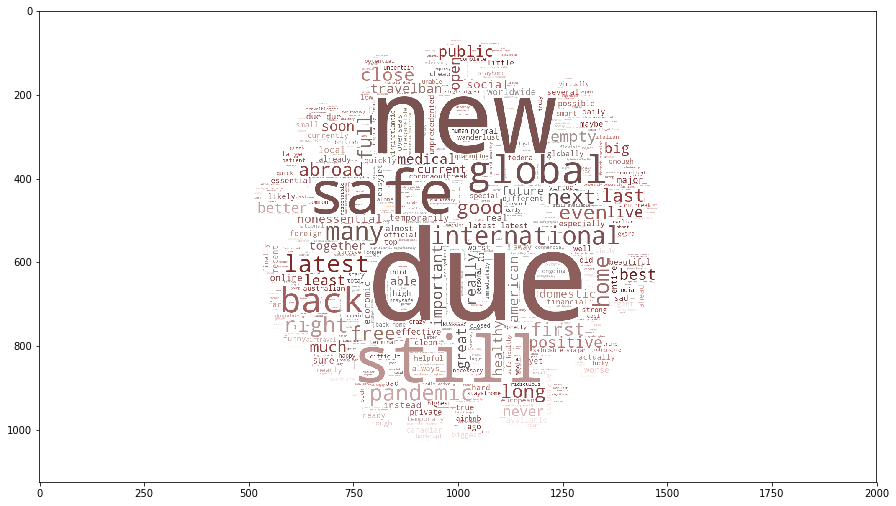

In [110]:
char_mask = np.array(Image.open("Viz/Coronavirus-CDC.jpg"))
image_colors = ImageColorGenerator(char_mask)

plt.figure(figsize=[15,15])
wc = WordCloud(background_color="white", 
               max_words=600, 
               width=400, 
               height=400, 
               mask=char_mask, 
               random_state=1).generate(text)
# to recolour the image
plt.imshow(wc.recolor(color_func=image_colors))
wc.to_file('Viz/cloud.png')

### Sentiment Analysis

In [51]:
def get_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    
    results = sid.polarity_scores(text)
    sentiment = results['compound']
    return sentiment

corpus_df = pd.DataFrame({'corpus': corpus})
corpus_df['sentiment'] = corpus_df['corpus'].apply(get_sentiment)

In [52]:
corpus_df.head()

,corpus,sentiment
0,,0.0000
1,still demanding altogether also immune,0.0772
2,still demanding altogether also immune,0.0772
3,new wary longest,0.0000
4,new wary longest,0.0000


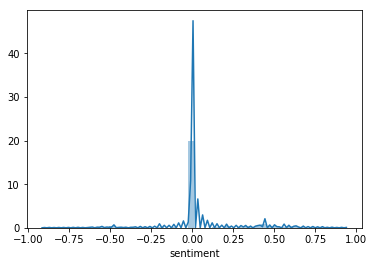

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(corpus_df['sentiment'])
plt.show()

In [55]:
def relabel_sentiment(num):
    if num > 0:
        return 'positive'
    if num < 0:
        return 'negative'
    if num == 0:
        return 'neutral'
    
corpus_df['category'] = corpus_df['sentiment'].apply(relabel_sentiment)

In [56]:
corpus_df['category'].value_counts()

neutral     6504
positive    1588
negative     695
Name: category, dtype: int64

In [60]:
neg_corpus_df = corpus_df.loc[corpus_df['category'] == 'negative',:]
pos_corpus_df = corpus_df.loc[corpus_df['category'] == 'positive',:]

### Word Clouds

In [85]:
neg_text = ' '.join(neg_corpus_df['corpus'])
pos_text = ' '.join(pos_corpus_df['corpus'])

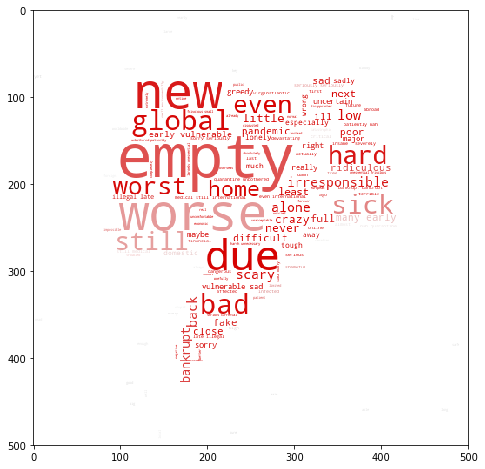

In [111]:
char_mask = np.array(Image.open("Viz/thumbs_down.jpg"))
image_colors = ImageColorGenerator(char_mask)

plt.figure(figsize=[8,8])
wc = WordCloud(background_color="white", 
               max_words=600, 
               width=400, 
               height=400, 
               mask=char_mask, 
               random_state=1).generate(neg_text)
# to recolour the image
plt.imshow(wc.recolor(color_func=image_colors))
wc.to_file('Viz/neg_cloud.png')

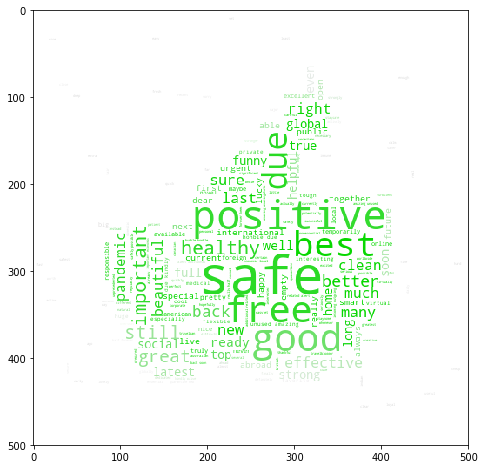

In [112]:
char_mask = np.array(Image.open("Viz/thumbs_up.png"))
image_colors = ImageColorGenerator(char_mask)

plt.figure(figsize=[8,8])
wc = WordCloud(background_color="white", 
               max_words=600, 
               width=400, 
               height=400, 
               mask=char_mask, 
               random_state=1).generate(pos_text)
# to recolour the image
plt.imshow(wc.recolor(color_func=image_colors))
wc.to_file('Viz/pos_cloud.png')

### K-means clustering

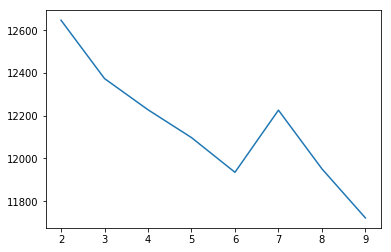

In [120]:
# Using the elbow method
wcss = []
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
    kmeans.fit(bow)
    wcss.append(kmeans.inertia_)
    
plt.figure()
plt.plot(range(2,10), wcss)
plt.show()

In [121]:
K_value = 6

kmeans = KMeans(n_clusters=K_value, init="k-means++")
kmeans.fit(bow)
clusters = kmeans.predict(bow)

In [123]:
# The number of words per cluster
pd.Series(clusters).value_counts()

2    8085
5     372
1     161
0     156
3       9
4       4
dtype: int64

In [124]:
corpus_df['cluster'] = clusters

In [127]:
# Defining cluster words
cluster0 = (' ').join(corpus_df[corpus_df['cluster'] == 0]['corpus'])
cluster1 = (' ').join(corpus_df[corpus_df['cluster'] == 1]['corpus'])
cluster2 = (' ').join(corpus_df[corpus_df['cluster'] == 2]['corpus'])
cluster3 = (' ').join(corpus_df[corpus_df['cluster'] == 3]['corpus'])
cluster4 = (' ').join(corpus_df[corpus_df['cluster'] == 4]['corpus'])
cluster5 = (' ').join(corpus_df[corpus_df['cluster'] == 5]['corpus'])

In [129]:
d0 = {word:cluster0.split().count(word) for word in cluster0.split()}
d1 = {word:cluster1.split().count(word) for word in cluster1.split()}
d2 = {word:cluster2.split().count(word) for word in cluster2.split()}
d3 = {word:cluster3.split().count(word) for word in cluster3.split()}
d4 = {word:cluster4.split().count(word) for word in cluster4.split()}
d5 = {word:cluster5.split().count(word) for word in cluster5.split()}

In [131]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

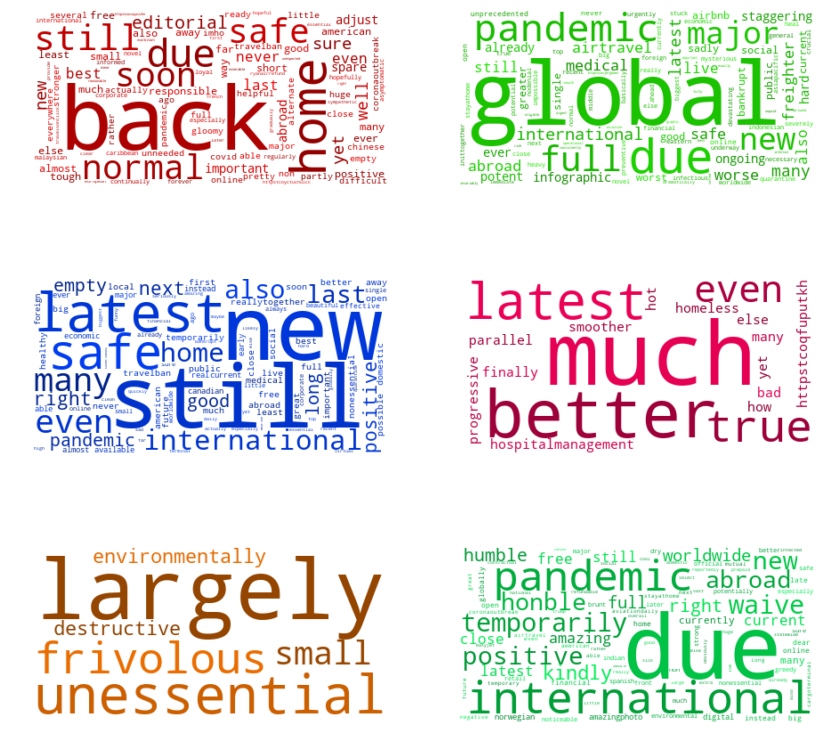

In [132]:
# Visualizing the word clouds
cluster_list = [d0, d1, d2, d3, d4, d5]
color = [0, 80, 160, 240, 20, 100]

fig = plt.figure(figsize=(14,14))

for i in range(K_value):
    ax1 = fig.add_subplot(3, 2, i + 1)
    tone = color[i]
    wordcloud = WordCloud(max_font_size=100, 
                          max_words=100, 
                          background_color="white",
                          color_func=random_color_func)
    wordcloud.generate_from_frequencies(frequencies=cluster_list[i])
    ax1.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

### Exporting data

In [115]:
corpus_df.to_csv('data/processed/corpus_df.csv')